# Topic Extraction Challenge
### Comparing LSA, LDA, and NNMF

#### Dataset: 20 newsgroups

#### Method:
1.  Parse and process the data into a tf-idf matrix.
2.  Fit LSA, LDA, and NNMF models with 5 topics each.
3.  Extract the words that best describe each topic.
4.  Examine the topic relationships for top words.

In [1]:
import pandas as pd
import numpy as np
import scipy

import spacy
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(27)

In [34]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('Set2')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [2]:
#Loading the data set - training data.
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(shuffle=True, remove=('headers', 'footers'))

In [3]:
type(newsgroups)

sklearn.utils.Bunch

In [4]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
df = pd.DataFrame(newsgroups.data, newsgroups.target).reset_index()
df.columns = ['target', 'data']
df.head()

,target,data
0,7,I was wondering if anyone out there could enli...
1,4,A fair number of brave souls who upgraded thei...
2,4,"well folks, my mac plus finally gave up the gh..."
3,1,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...
4,14,"From article <C5owCB.n3p@world.std.com>, by to..."


In [7]:
sample_data = df.iloc[0,1]
sample_data

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [10]:
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [11]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_numeric
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short

CUSTOM_FILTERS = [lambda x: x.lower(), #lowercase
                  strip_tags, # remove html tags
                  strip_punctuation, # replace punctuation with space
                  strip_multiple_whitespaces,# remove repeating whitespaces
                  strip_non_alphanum, # remove non-alphanumeric characters
                  strip_numeric, # remove numbers
                  remove_stopwords,# remove stopwords
                  strip_short # remove words less than minsize=3 characters long
                 ]
nlp = spacy.load('en')

def gensim_preprocess(docs, logging=True):
    docs = [expandContractions(doc) for doc in docs]
    docs = [preprocess_string(text, CUSTOM_FILTERS) for text in docs]
    texts_out = []
    for doc in docs:
    # https://spacy.io/usage/processing-pipelines
        doc = nlp((" ".join(doc)),  # doc = text to tokenize => creates doc
                  # disable parts of the language processing pipeline we don't need here to speed up processing
                  disable=['ner', # named entity recognition
                           'tagger', # part-of-speech tagger
                           'textcat', # document label categorizer
                          ])
        texts_out.append([tok.lemma_ for tok in doc if tok.lemma_ != '-PRON-'])
    return pd.Series(texts_out)

gensim_preprocess(df.data.iloc[10:15])

0    [line, ducati, gts, model, clock, run, paint, ...
1    [article, freenet, carleton, freenet, carleton...
2                                                   []
3    [article, kjenks, gothamcity, jsc, nasa, gov, ...
4    [reduce, price, list, thing, forsale, behalf, ...
dtype: object

In [12]:
texts = gensim_preprocess(df.data)

In [17]:
texts = [' '.join(text) for text in texts]
texts[0]

'wonder enlighten car see day door sport car look late early call bricklin door small addition bumper separate rest body know tellme model engine spec year production car history info funky look car mail'

In [29]:
# sklearn tfidf
vectorizer = TfidfVectorizer()
sklearn_tfidf = vectorizer.fit_transform(texts)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=len(newsgroups.target_names)

# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

In [19]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
%time lsa = lsa.fit_transform(sklearn_tfidf)

components_lsa = word_topic(sklearn_tfidf, lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


CPU times: user 929 ms, sys: 107 ms, total: 1.04 s
Wall time: 674 ms


In [20]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7,# Convergence rate.
          learning_method='online',
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.01, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=10, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
         )

%time lda = lda.fit_transform(sklearn_tfidf) 

components_lda = word_topic(sklearn_tfidf, lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


CPU times: user 3min 19s, sys: 5min 3s, total: 8min 22s
Wall time: 9min 10s


In [21]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
%time nmf = nmf.fit_transform(sklearn_tfidf) 

components_nmf = word_topic(sklearn_tfidf, nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

CPU times: user 6.57 s, sys: 287 ms, total: 6.86 s
Wall time: 5.69 s


In [22]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
             LSA           LDA         NNMF
0   write 140.67    write 1.74  people 3.08
0  article 116.0  article 1.44    think 2.6
0    know 108.15     know 1.41    know 2.38
0     edu 105.28      edu 1.34    like 2.21
0     like 99.22    thank 1.25   write 2.18
0    think 98.71     like 1.18    time 1.92
0   people 93.01    think 1.08  article 1.8
0     time 80.67   window 1.07      say 1.8
0      com 77.78      com 0.97   thing 1.76
0       use 74.4      use 0.95      go 1.73
Topic 1:
             LSA           LDA              NNMF
1   window 59.04    write 1.79       window 8.86
1    thank 31.84  article 1.47          dos 2.33
1     file 31.64     know 1.46          run 1.92
1     card 31.07       edu 1.4          file 1.8
1    drive 26.34    thank 1.28      program 1.62
1      dos 23.48     like 1.25          use 1.42
1  program 22.14    think 1.12        driver 1.3
1   driver 21.44   window 1.09       problem 1.3
1      use 19.86      com 0.99  application 1.28
1      r

In [32]:
len(newsgroups.target_names)

20

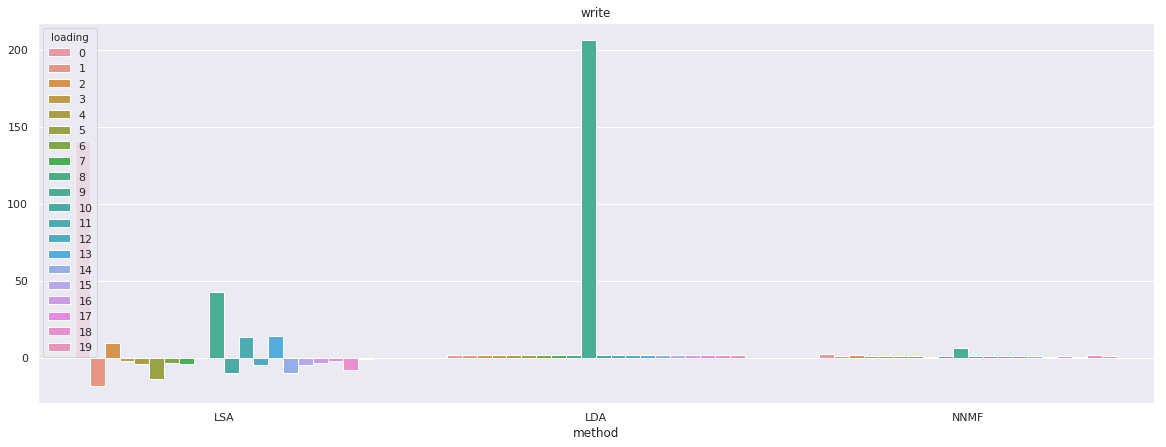

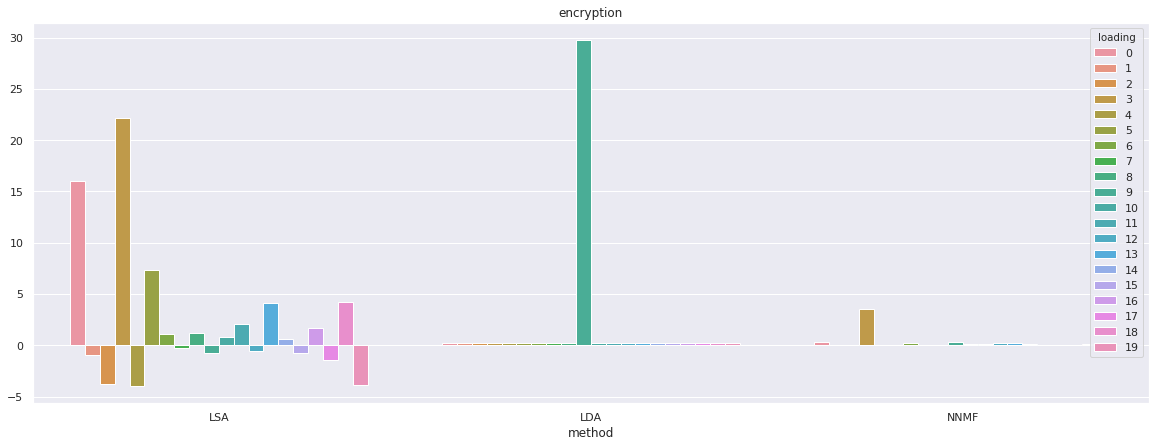

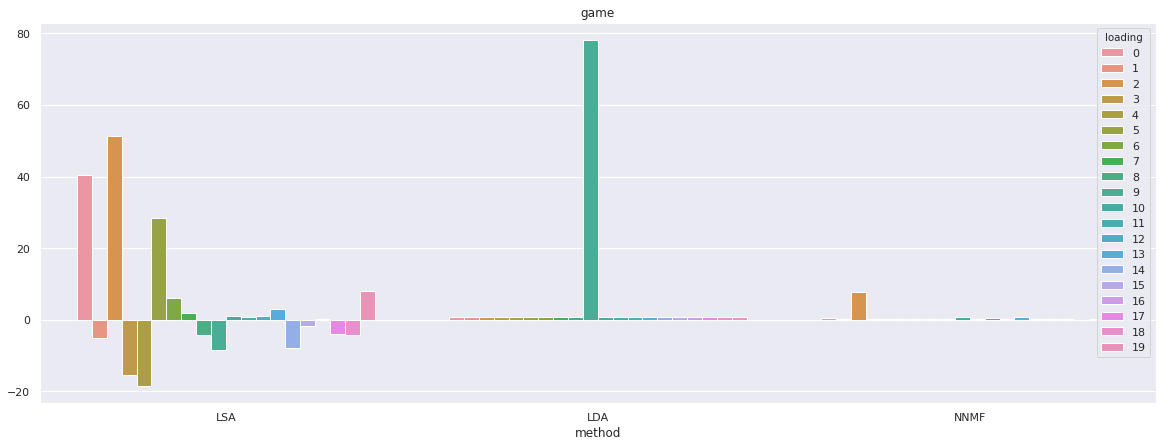

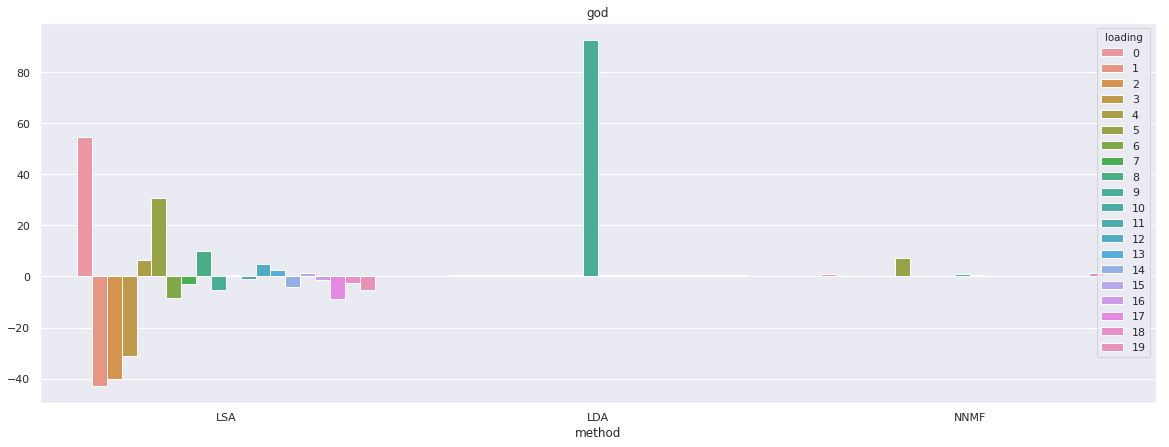

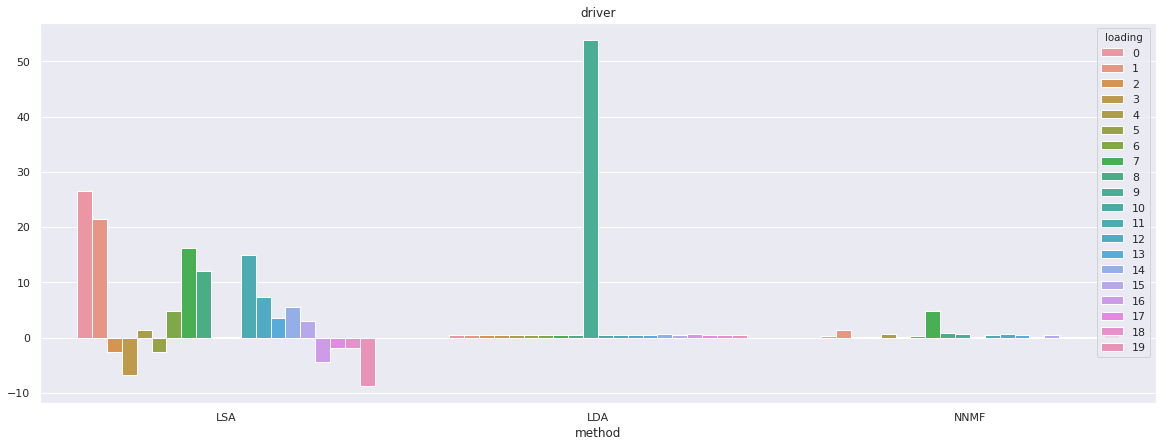

In [35]:
# The words to look at.
targetwords=['write','encryption','game', 'god', 'driver']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], len(newsgroups.target_names), axis=0)
wordloadings['loading']=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

LSA is the method most likely to have high loadings on more than one topic for the same word. LDA tends to have one high loading and some lower loadings. Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.

According to [NLP for Hackers](https://nlpforhackers.io/topic-modeling/) topic modeling is:

 - Dimensinality Reduction - We reduce dimensionality by representing a text in its topic space instead of its word space.
 - Unsupervised Learning - Topic modeling is similar to clustering.
 - A Form of Tagging - Topic modeling applys multiple tags to a text. (Similar to the tags applied to this kernel above!)

Topic modeling is useful for many situations, including text classification.